In [2]:
import sample_measure_lib

In [345]:
import lxml
import trimesh
import os
import sys


import numpy as np
from math import sin, cos, atan, pi, sqrt, pow

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.gridspec as gridspec

from sample_measure_lib.calcs import *
from sample_measure_lib.draws import *
from sample_measure_lib.draws_io import ImageHandler, ImageHandlerNull
from sample_measure_lib.formats import *
from sample_measure_lib.experiments import *


In [113]:
from importlib import reload
import sample_measure_lib
_ = reload(sample_measure_lib)

import sample_measure_lib.draws_io

img_handler = ImageHandlerNull()

def validate_samples_or_fail(xy_samples, points, img_handler):
    pass


Reading 3mf file data/File.3mf
Loaded 204303 3d points
w: 88.906, h: 49.004999999999995, d: 88.906
Rotate: -54.895535283575256 degree
Rotate: 2.1240272636300634 degree
generate grid 184x180 with z: -0.515 step: 0.5
generate grid 920x900 with z: 0.000 step: 0.1
interpolate_points begin real: 686577 grid: 2484000
interpolate_points completed
detect_lines in (900, 920)
calc_rotate_angle_degree angles: (array([-33., -30., -27., -24., -21., -18.,  57.,  60.,  63.,  66.,  69.,
        72.]), array([ 1,  4,  6, 24, 12,  6,  2,  2,  8, 20, 13,  5]))
angles: (array([-33., -30., -27., -24., -21., -18.,  57.,  60.,  63.,  66.,  69.,
        72.]), array([ 1,  4,  6, 24, 12,  6,  2,  2,  8, 20, 13,  5]))
Rotate: 24.0 degree
Found 16 samples
Rotate: 0.5 degree
Found 16 samples
Rotate: -0.5 degree
Found 16 samples
Rotate: 1.6250000000000002 degree
Found 16 samples
Rotate: -1.6250000000000002 degree
Found 16 samples
Rotate: 2.7499999999999996 degree
Found 16 samples
Rotate: -2.7499999999999996 degree

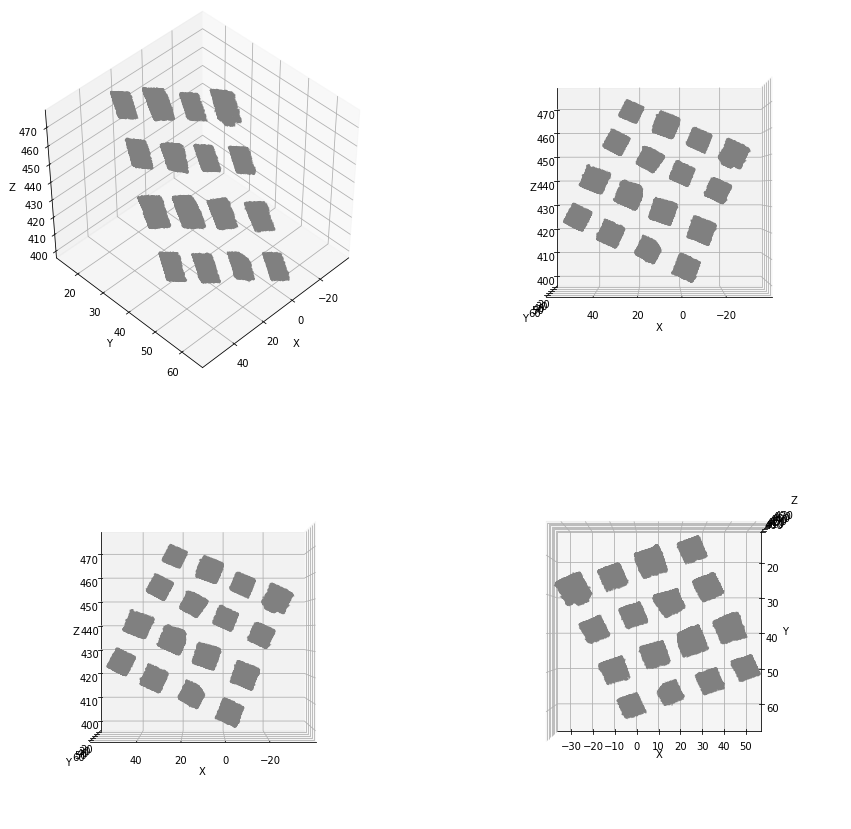

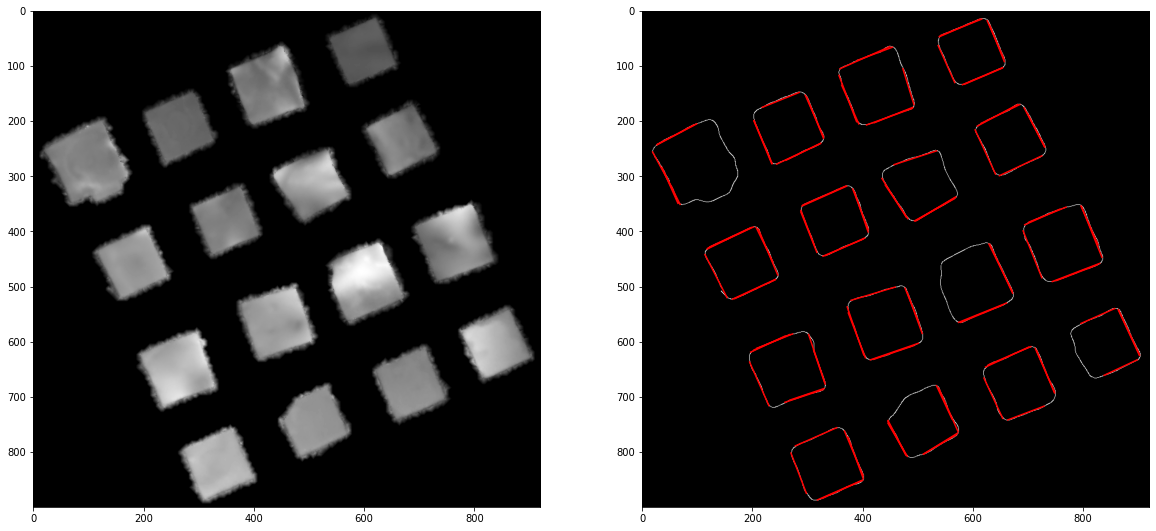

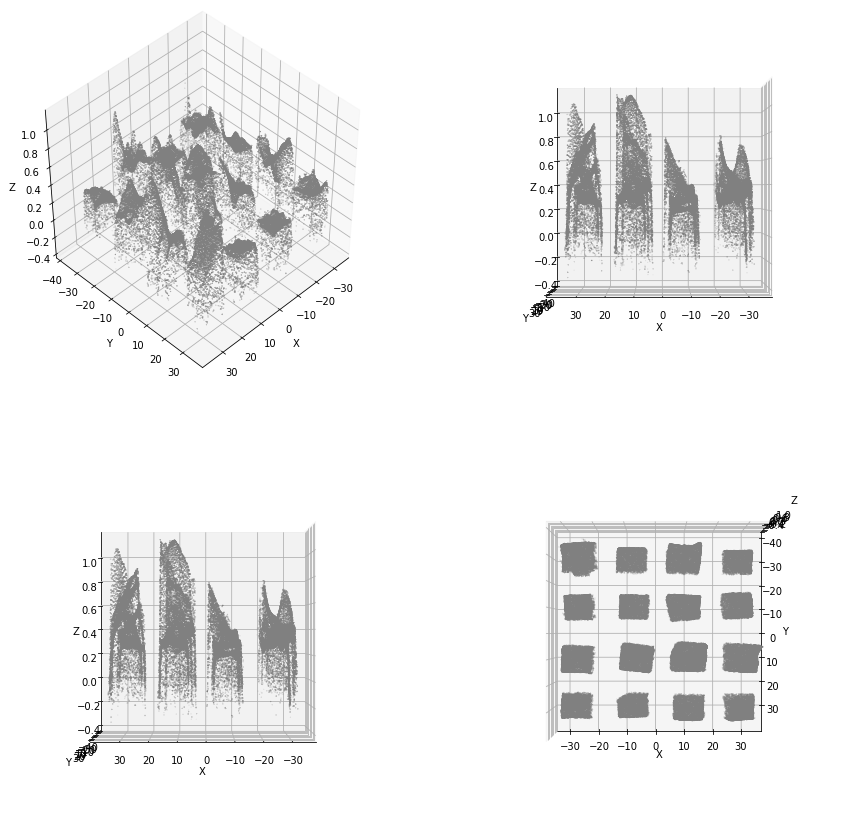

In [336]:
path = "data/XY Cal a.3mf"
path = "data/File.3mf"
#path = "data/Corner discs 1.3mf"
#path = "data/Corner Coins2.3mf"
os.path.exists(path)



#


points = load_points(path)

draw_points4ex(plt, points)

# x_arr, y_arr, z_arr = xyz_cols(points)

img_handler.draw_points4_and_save(points, '3d-origin')


def zero_normalize_points(points):
    x_arr, y_arr, z_arr = xyz_cols(points)
    z_arr = [-z for z in z_arr]
    move_zero(x_arr, y_arr, z_arr)
    points = [(x_arr[i], y_arr[i], z_arr[i]) for i in range(len(x_arr))]
    return points


def rotate_flat_z(points):
    x_arr, y_arr, z_arr = xyz_cols(points)
    r = polyfit_line2rad(ycol(points), zcol(points))
    rotate_xy_rad(y_arr, z_arr, -r)
    points = col2points(x_arr, y_arr, z_arr)

    r = polyfit_line2rad(xcol(points), zcol(points))
    rotate_xy_rad(x_arr, z_arr, -r)
    points = col2points(x_arr, y_arr, z_arr)
    return points


def rotate_points_xy_auto90(points):
    inter_points, xy_shape = scatter_to_grid_points(points)
    img, lines = detect_lines(inter_points, xy_shape)
    xy_d = calc_rotate_angle_degree(lines)
    xy_r = deg2rad(xy_d)
    return rotate_points_xy(points, -xy_r)


def rotate_points_xy(points, xy_r):
    x_arr, y_arr, z_arr = xyz_cols(points[:])
    rotate_xy_rad(x_arr, y_arr, xy_r)
    points = col2points(x_arr, y_arr, z_arr)
    return points


def rotate_points_xy_max_samples(points):
    max_samples = len(split_samples(points)[0])
    max_d = 0
    
    micro_angles = sorted(list(np.linspace(0.5,5.,5)) + list(np.linspace(-0.5,-5,5)), key=abs)
    for d in micro_angles:
        r_points = rotate_points_xy(points, deg2rad(d))
        xy_samples, _, _ = split_samples(r_points)
        if len(xy_samples) > max_samples:
            max_samples = len(xy_samples)
            max_d = d
                
    print("Found max samples {} at {} degree".format(max_samples, max_d))
    return rotate_points_xy(points, deg2rad(max_d))


def rotate_flat_z_micro(points):
    points = points[:]
    
    # rotate X/Z
    xy_samples, x_rows, y_rows = split_samples(points)
    xy_lows = calc_lows(xy_samples)
    x_angles = cacl_x_angles_by_rows(xy_lows, x_rows, y_rows)
    #x_angles = calc_x_angles_by_corners(xy_samples, x_rows, y_rows)

    r = sum(x_angles)/len(x_angles)
    rotate_points_xy_rad(points, X_AXIS, Z_AXIS, -r)
    
    # rotate X/Z
    xy_samples, x_rows, y_rows = split_samples(points)
    y_angles = calc_y_angles_by_rows(xy_lows, x_rows, y_rows)
    #y_angles = calc_y_angles_by_corners(xy_samples, x_rows, y_rows)

    r = sum(y_angles)/len(y_angles)
    rotate_points_xy_rad(points, Y_AXIS, Z_AXIS, -r)
    return points


points = zero_normalize_points(points)
points = rotate_flat_z(points)
points = rotate_points_xy_auto90(points)
points = rotate_points_xy_max_samples(points)
points = rotate_flat_z_micro(points)

xy_samples, _, _ = split_samples(points)

draw_points4ex(plt, points)



# rotate horizontally to parallel with x and y axis



# # rotate horizontally to parallel with x and y axis
# xy_r = calc_xy_rad_by_corner(points)
# rotate_xy_rad(x_arr, y_arr, xy_r)
# all_points = col2points(x_arr, y_arr, z_arr)


# # split samples
# xy_samples, x_rows, y_rows = split_samples(all_points)
# validate_samples_or_fail(xy_samples, all_points, img_handler)

# # fine tune vertically to make flat

# # rotate Y/Z
# xy_lows = calc_lows(xy_samples)
# x_angles = cacl_x_angles_by_rows(xy_lows, x_rows, y_rows)
# #x_angles = calc_x_angles_by_corners(xy_samples, x_rows, y_rows)

# r = sum(x_angles)/len(x_angles)
# rotate_points_xy_rad(all_points, X_AXIS, Z_AXIS, -r)

# # rotate X/Z
# xy_samples, _, _ = split_samples(all_points)
# y_angles = calc_y_angles_by_rows(xy_lows, x_rows, y_rows)
# #y_angles = calc_y_angles_by_corners(xy_samples, x_rows, y_rows)

# r = sum(y_angles)/len(y_angles)
# rotate_points_xy_rad(all_points, Y_AXIS, Z_AXIS, -r)

# # move up-down to baseline along Z
# adjust_zero_base(all_points)
# x_arr, y_arr, z_arr = xyz_cols(all_points)

# xy_samples, _, _ = split_samples(all_points)
# validate_samples_or_fail(xy_samples, all_points, img_handler)


# # print_thinkness_csv(xy_samples, path)

# x_arr, y_arr, z_arr = xcol(all_points), ycol(all_points), zcol(all_points)
# img_handler.draw_points4_and_save(all_points, '3d-rotated')


# draw_points4ex(plt, points)

In [248]:
print_thinkness_csv(xy_samples, path)


SAMPLE     | MAX        | X          | Y         
01         | 0.903      | -36        | -28       
02         | 0.357      | -15        | -30       
03         | 1.121      | +01        | -30       
04         | 0.926      | +17        | -31       
05         | 0.783      | -32        | -13       
06         | 0.617      | -14        | -15       
07         | 1.119      | +02        | -15       
08         | 0.712      | +21        | -17       
09         | 0.776      | -32        | +07       
10         | 0.821      | -12        | +14       
11         | 1.282      | +05        | +08       
12         | 1.184      | +23        | +13       
13         | 0.942      | -31        | +29       
14         | 0.401      | -13        | +28       
15         | 0.470      | +07        | +32       
16         | 0.898      | +23        | +28       
Writing results in csv data/Corner discs 1.csv


generate grid 144x150 with z: -0.339 step: 0.5
generate grid 720x750 with z: 0.000 step: 0.1
interpolate_points begin real: 652107 grid: 1620000
interpolate_points completed
Found 16 samples
w: 10.114047287899862, h: 9.913217623498, d: 10.114047287899862


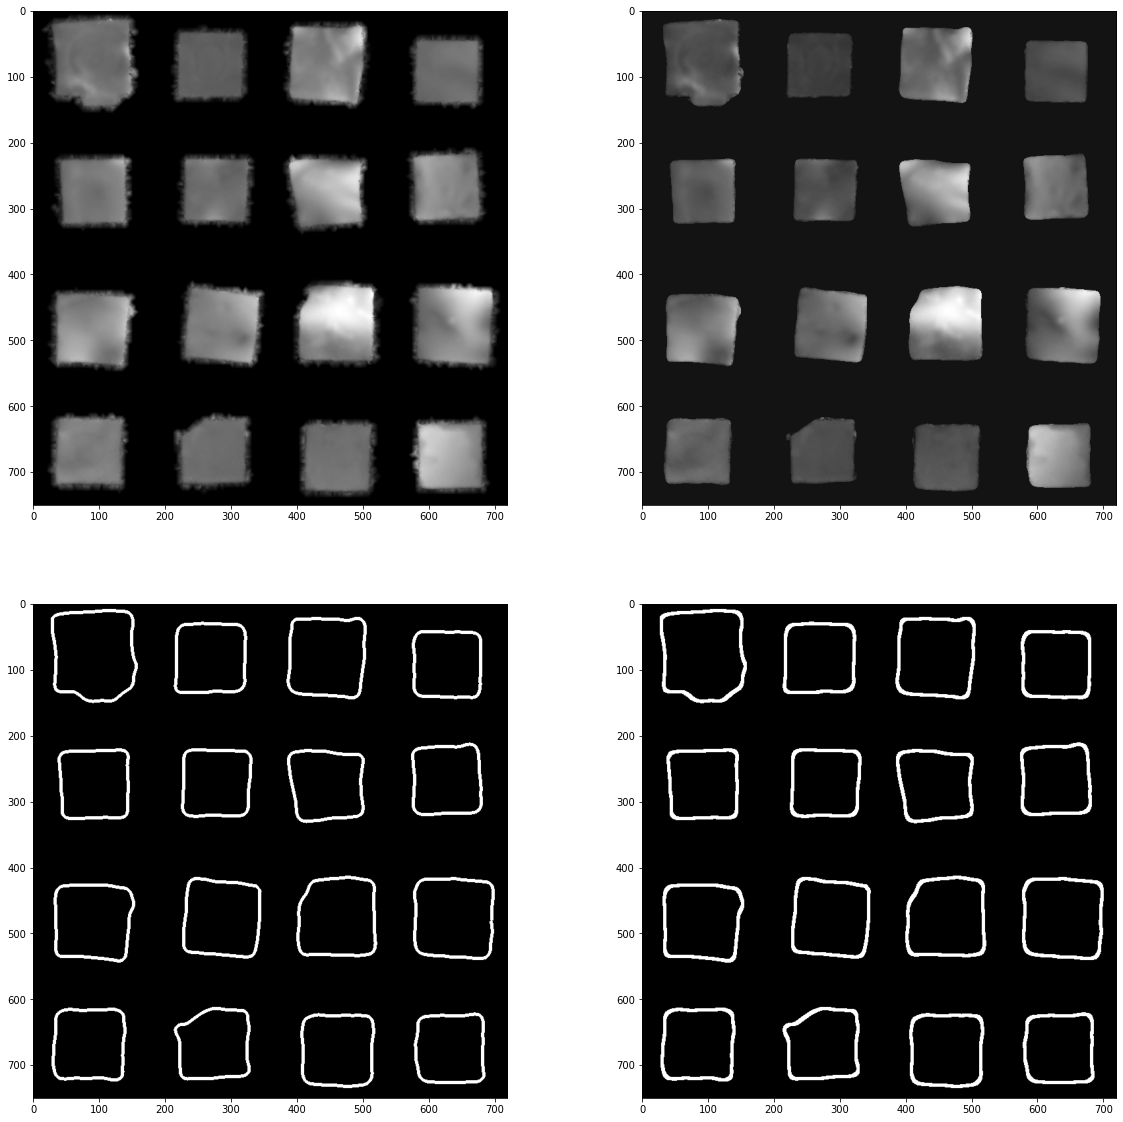

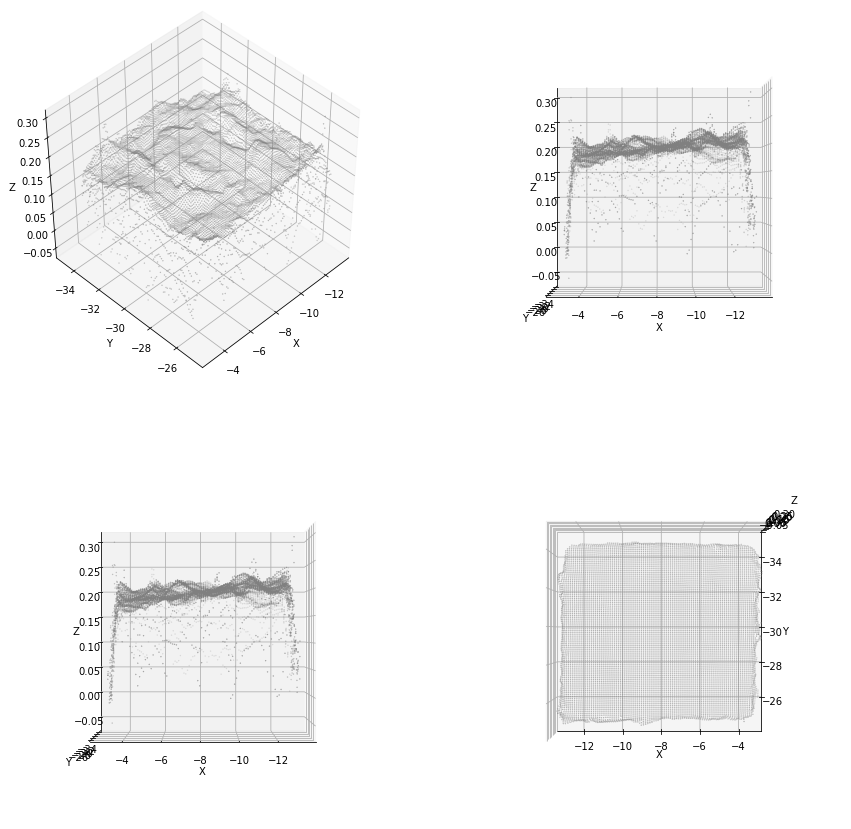

In [344]:
inter_points, xy_shape = scatter_to_grid_points(points)
img, shape_points = filter_shape_edges(inter_points, xy_shape)
xy_samples, _, _ = split_samples(shape_points)
shape_points = xy_samples[1]
_ = fdraw_points4ex(plt, shape_points, s=0.1)

In [347]:
len(shape_points)


9565

In [102]:
import math

def calc_frame(points, margin=1):
    points = np.array(points)
   
    xmin = np.min(points[:,0])
    xmax = np.max(points[:,0])
    ymin = np.min(points[:,1])
    ymax = np.max(points[:,1])
    
    xmin = math.floor(xmin - margin)
    xmax = math.ceil(xmax + margin)
    
    ymin = math.floor(ymin - margin)
    ymax = math.ceil(ymax + margin)
    
    return [(xmin, ymin), (xmax,ymax)]

In [103]:
def build_grid(points, grid_step, z_val=0):
    points = np.array(points)
   
    corners = calc_frame(points)
    x_lim = corners[0][0], corners[1][0]
    y_lim = corners[0][1], corners[1][1]
    
    xy_shape = (
            int(abs(x_lim[1]-x_lim[0])/grid_step),
            int(abs(y_lim[1]-y_lim[0])/grid_step)
        )
    
    print("generate grid {}x{} with z: {:.3f} step: {}".format(xy_shape[0], xy_shape[1], z_val, grid_step))
    
    x_grid = np.linspace(x_lim[0], x_lim[1], xy_shape[0])
    y_grid = np.linspace(y_lim[0], y_lim[1], xy_shape[1])

    B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
    Z = np.ones(len(B1.ravel())) * z_val

    return np.vstack([B1.ravel(),B2.ravel(),Z.ravel()]).T, xy_shape
    

In [104]:
from scipy import spatial


def find_space_points(points, grid_step=0.5):
    points = np.array(points)
    
    z_base = np.min(points[:,2])
    grid_points, xy_shape = build_grid(points, grid_step, z_base)
    
    real_points_tree = spatial.KDTree(points[:,:2])
    indexes = real_points_tree.query(grid_points[:,:2], distance_upper_bound=grid_step)
    indexes = np.isinf(indexes[0])
    return grid_points[indexes]


In [105]:
import scipy as sp
import scipy.interpolate

def interpolate_points(real_points, grid_points, xy_shape):
   
    print("interpolate_points begin real: {} grid: {}".format(real_points.size, grid_points.size))

    xy_real = real_points[:,:2]
    x_real = real_points[:,2]
    interp = sp.interpolate.LinearNDInterpolator(xy_real, x_real, fill_value=0)
    # interp = sp.interpolate.NearestNDInterpolator(xy_real, x_real)
    # interp = sp.interpolate.Rbf(bx,by,x_real,smooth=1, episilon=1)
    
    B1 = grid_points[:,0].reshape(xy_shape[0], xy_shape[1])
    B2 = grid_points[:,1].reshape(xy_shape[0], xy_shape[1])
    Z = interp(B1,B2)

    print("interpolate_points completed")
    return np.vstack([B1.ravel(),B2.ravel(),Z.ravel()]).T


In [342]:
from scipy.ndimage import gaussian_filter
from skimage import filters
from skimage import feature
from skimage import measure
from skimage import segmentation
from skimage.morphology import square, dilation
from skimage.transform import probabilistic_hough_line


def detect_lines(points, xy_shape):
    img = points[:,2].reshape(xy_shape[1], xy_shape[0])
    img2 = gaussian_filter(img, sigma=4)
    img4 = feature.canny(img2, sigma=5)
    img4 = np.where(img4, 1.0, 0)
    img6 = segmentation.flood_fill(img4, (1, 1), 1.0, connectivity=1)
    
    print("detect_lines in {}".format(img.shape))
    lines = probabilistic_hough_line(img4, threshold=5, line_length=60, line_gap=20)
    
    
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.imshow(img, cmap=plt.cm.gray)
    ax2.imshow(img4, cmap=plt.cm.gray)
    
    for line in lines:
        p0, p1 = line
        ax2.plot((p0[0], p1[0]), (p0[1], p1[1]), c='r')

    return img6, lines


def filter_shape_edges(points, xy_shape):
    img = points[:,2].reshape(xy_shape[1], xy_shape[0])
    img2 = gaussian_filter(img, sigma=4)
    img4 = feature.canny(img2, sigma=5)
    img4a = np.where(img4, 1.0, 0.)
    
    s = square(5)
    s[:,:] = 0
    s[:,2] = 1
    s[2,:] = 1

    img4 = dilation(img4a, s)
    img4b = dilation(img4a, square(5))

    img6 = segmentation.flood_fill(img4, (1, 1), 1.0, connectivity=1)    
    i = img6.ravel() == 0
    shape_points = points[i]
    
    img7 = np.where(img6, 0, img)
    
    # debug begin
    
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    ax1.imshow(img, cmap=plt.cm.gray)
    ax2.imshow(img7, cmap=plt.cm.gray)
    ax3.imshow(img4, cmap=plt.cm.gray)
    ax4.imshow(img4b, cmap=plt.cm.gray)
    
    # debug end
    
    return img, shape_points


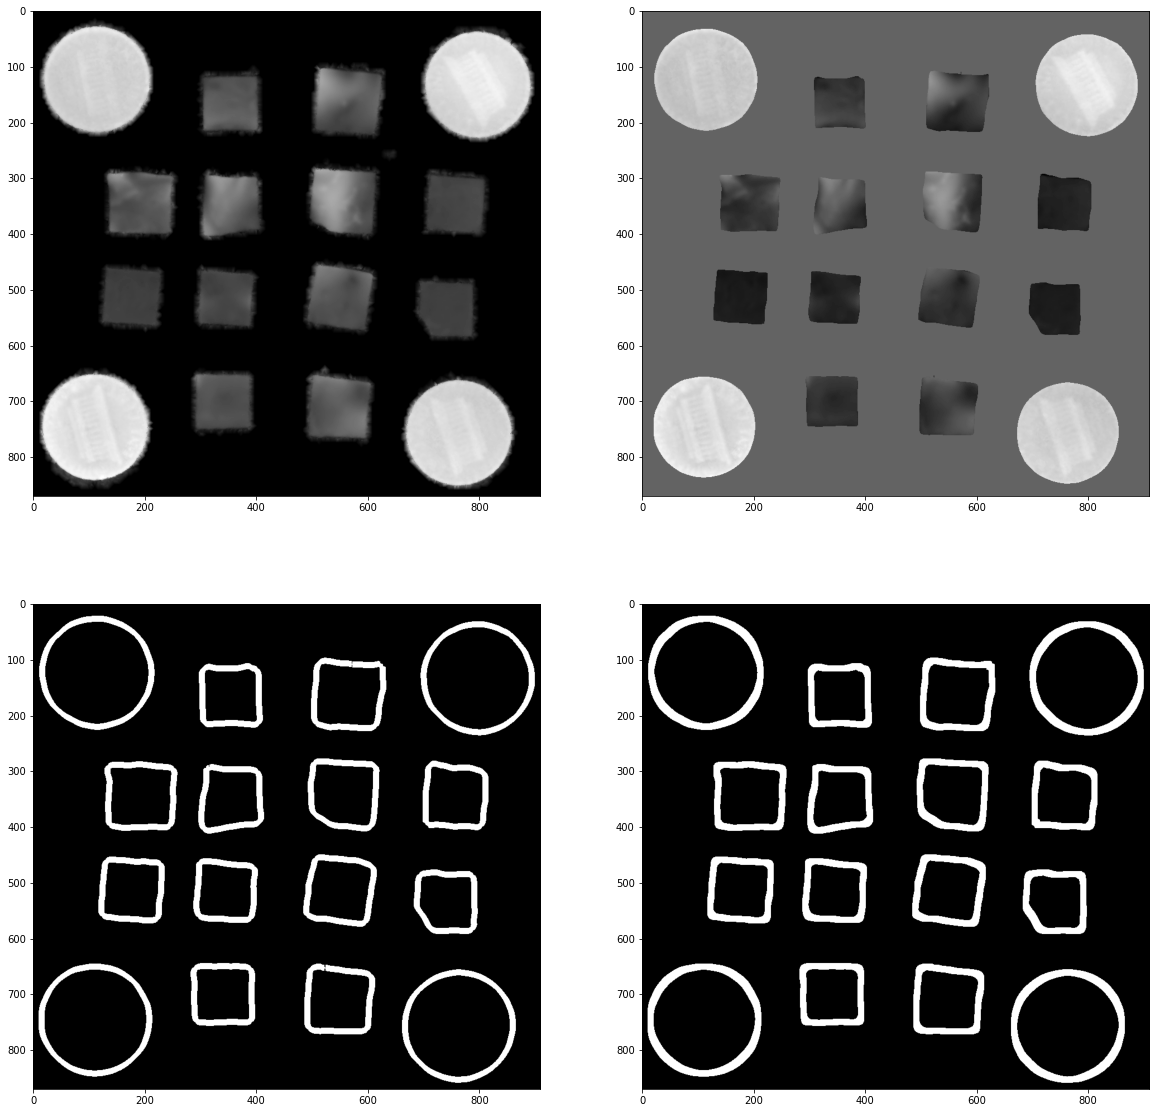

In [335]:
img, shape_points = filter_shape_edges(inter_points, xy_shape)

In [324]:
s = square(11)
s[:,:] = 0
s[:,5] = 1
s[5,:] = 1
s

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

In [126]:
def scatter_to_grid_points(points):
    points = np.array(points)
    space_points = find_space_points(points, 0.5)
    grid_points, xy_shape = build_grid(points, 0.1)

    real_points = np.vstack([points, space_points])
    inter_points = interpolate_points(real_points, grid_points, xy_shape)
    return inter_points, xy_shape


detect_lines in (1030, 770)


35

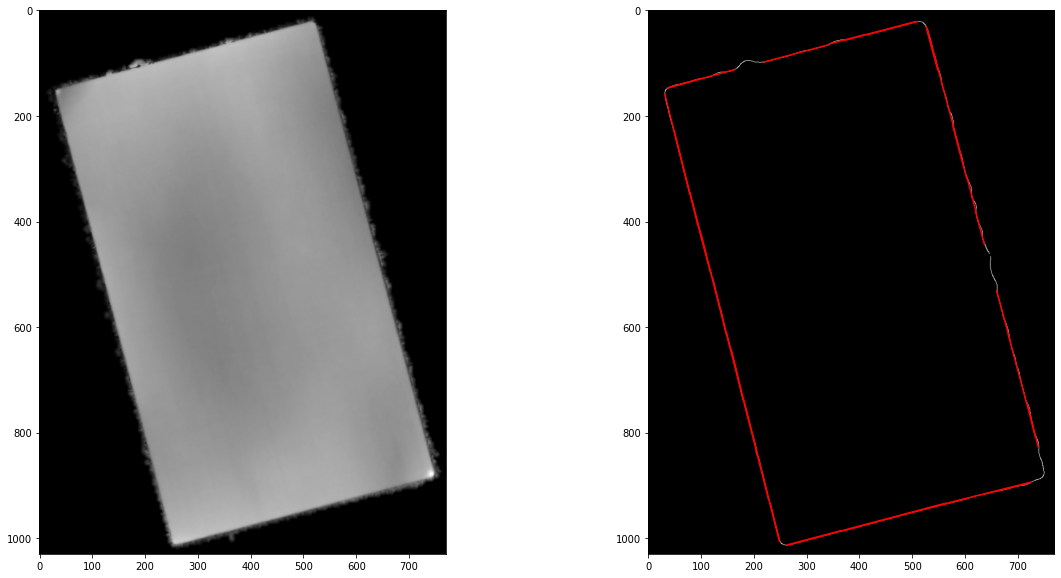

In [155]:
# inter_points, xy_shape = scatter_to_grid_points(all_points)

img, lines = detect_lines(inter_points, xy_shape)
#r = calc_rotate_angle_degree(lines)
#_ = draw_points4(plt, inter_points)

len(lines)

In [302]:
from math import atan
import scipy.constants as consts

def calc_rotate_angle_degree(lines):
    angles = []
    round_degrees = 3

    for line in lines:
        p0, p1 = line
        h = p1[1] - p0[1]
        w = p1[0] - p0[0]
        if w and h:
            r = atan(h/w)
            a = r/consts.degree
            angles.append(a)
        
    angles =  np.unique(np.around(np.array(angles)/round_degrees)*round_degrees, return_counts=True)
    print("calc_rotate_angle_degree angles: {}".format(angles))
    
    most_angles = sorted(np.array(angles).T, key=lambda it: it[1])[-2:]
    if not most_angles:
        print("Unable to determine rotation angle from {}".format(angles))
        return 0
    
    d = sorted(most_angles, key=lambda it: it[0])[0][0]
    print("angles: {}".format(angles))
    angles = [a for a in angles[0] if abs(a - d) < round_degrees/2]
    d = sum(angles)/len(angles)
    return d

# calc_rotate_angle_degree(lines)

[array([-14.,  10.]), array([76., 19.])]

Found 16 samples
w: 18.019586507072905, h: 18.219382321618745, d: 18.219382321618745


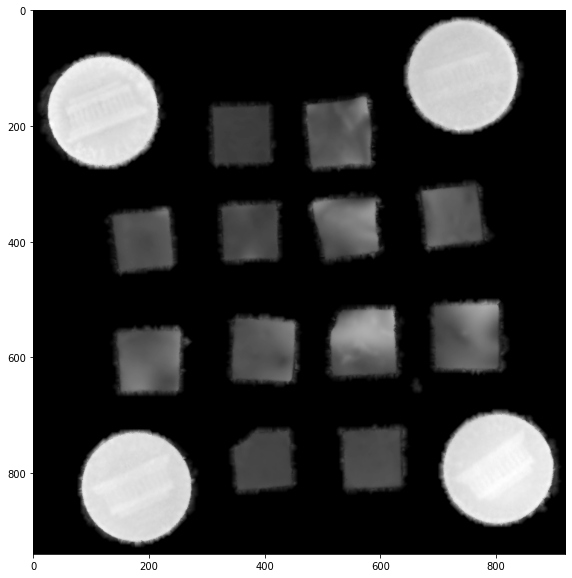

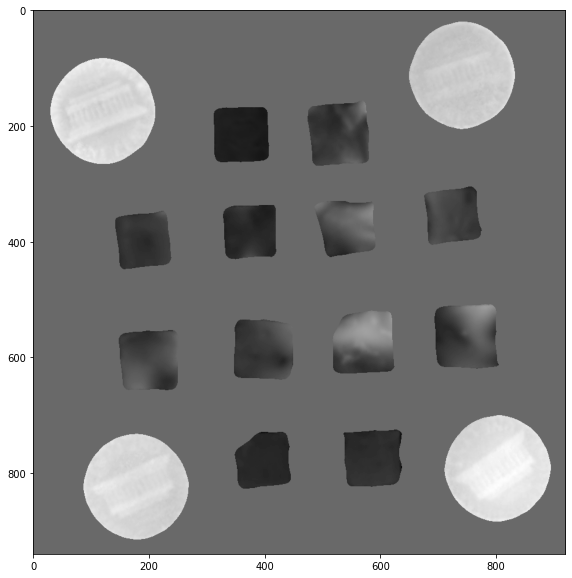

<Figure size 1440x720 with 0 Axes>

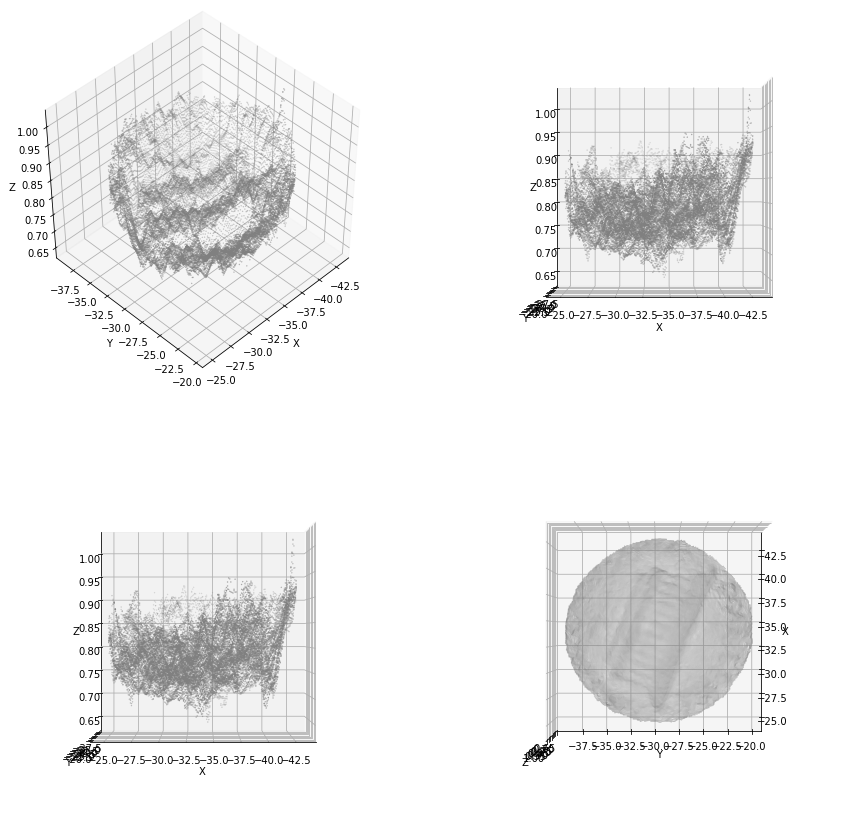

In [305]:
img, shape_points = filter_shape_edges(inter_points, xy_shape)
xy_samples, _, _ = split_samples(shape_points)
shape_points = xy_samples[0]
_ = draw_points4ex(plt, shape_points, s=0.1)


#img = shape_points[:,2].reshape(xy_shape[1], xy_shape[0])

w: 18.019586507072905, h: 18.219382321618745, d: 18.219382321618745


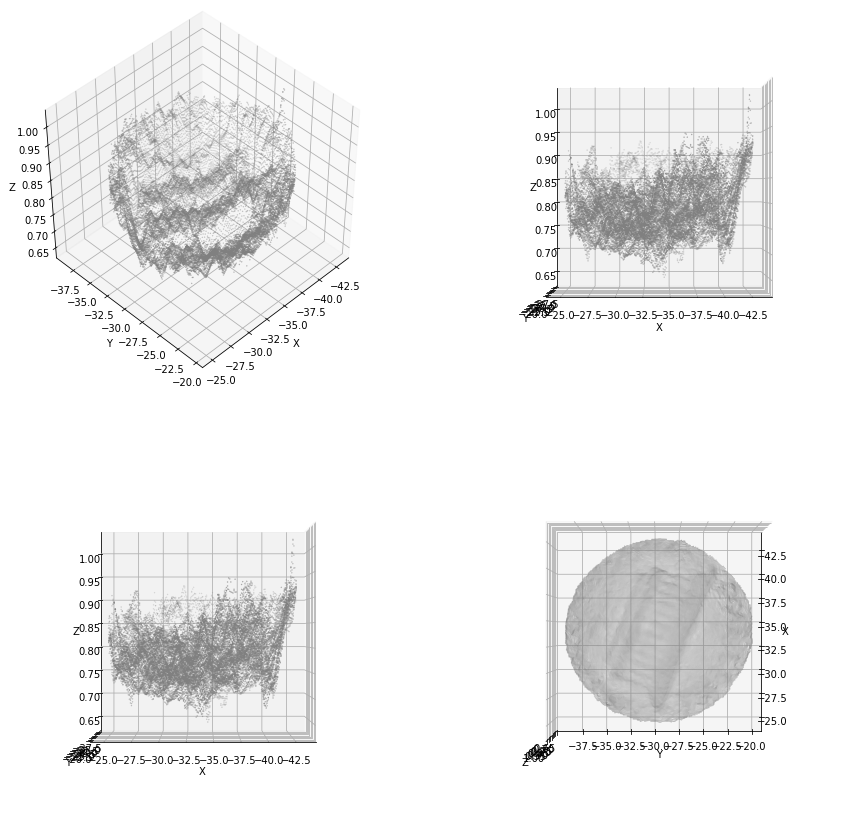

In [297]:
shape_points = xy_samples[0]
_ = draw_points4ex(plt, shape_points, s=0.1)

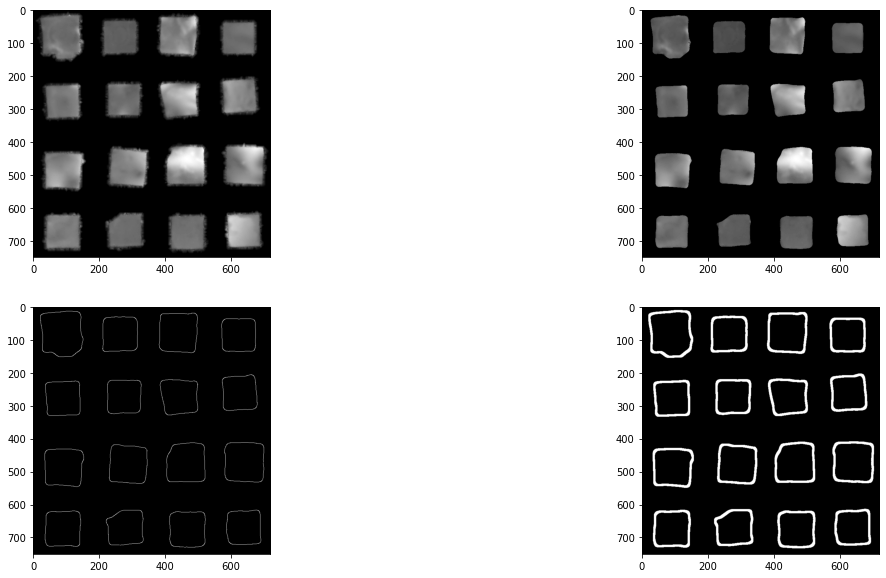

In [110]:
img, shape_points = filter_shape_edges(inter_points, xy_shape)

In [308]:
def draw_points4ex(plt, all_points, s=0.01):
    x_arr, y_arr, z_arr = xcol(all_points), ycol(all_points), zcol(all_points)
    
    xmin, xmax = min(x_arr), max(x_arr)
    ymin, ymax = min(y_arr), max(y_arr)
    zmin, zmax = min(z_arr), max(z_arr)
    
    w = abs(abs(xmax - xmin))
    h = abs(abs(ymax - ymin))
    d = max(w, h)
    print("w: {}, h: {}, d: {}".format(w, h, d))

    fig = plt.figure(figsize=(15, 15))
    ax1 = plt.subplot(221, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.view_init(elev=45, azim=45)
    ax1.scatter(x_arr, y_arr, z_arr, s=s, c='gray')

    ax1 = plt.subplot(222, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.view_init(elev=0, azim=90)
    ax1.scatter(x_arr, y_arr, z_arr, s=s, c='gray')

    ax1 = plt.subplot(223, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
#     ax1.set_xlim(xmin-1, xmax+1)
#     ax1.set_ylim(ymin-1, ymax+1)
#     ax1.set_zlim(0, 2)
    
    ax1.view_init(elev=0, azim=90)
    ax1.scatter(x_arr, y_arr, z_arr, s=s, c='gray')

    ax1 = plt.subplot(224, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim(xmax, xmin)
    #ax1.set_ylim(ymin-1, ymax+1)
    ax1.view_init(elev=90, azim=90)
    ax1.scatter(x_arr, y_arr, z_arr, s=s, c='gray')